In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [88]:
train_images.shape

(50000, 32, 32, 3)

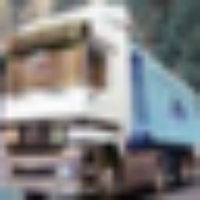

In [5]:
cv2_imshow(cv2.resize(train_images[1], (200,200)))

In [0]:
train_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)[:,:,np.newaxis] for image in train_images], dtype=np.float32)
# multiply last channel to keep grayscale image as a 3 channeled image
# train_images_gray = np.zeros_like(train_images)
# train_images_gray[:,:,:,0] = train_images_gray_1ch
# train_images_gray[:,:,:,1] = train_images_gray_1ch
# train_images_gray[:,:,:,2] = train_images_gray_1ch

In [97]:
train_images_gray.shape

(50000, 32, 32, 1)

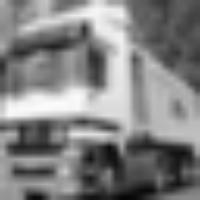

In [98]:
cv2_imshow(cv2.resize(train_images_gray[1], (200,200)))

In [0]:
class Generator(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.input_ = tf.keras.layers.InputLayer(input_shape=(32, 32, 1))
        self.conv1 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")
        self.conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")
        self.conv3 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", activation="relu")
        self.batch_norm = tf.keras.layers.BatchNormalization()
    
    @tf.function
    def call(self, inputs):
        x = self.input_(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.batch_norm(x)
        return x

In [73]:
G.summary()

Model: "generator_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_88 (Conv2D)           multiple                  3584      
_________________________________________________________________
conv2d_89 (Conv2D)           multiple                  147584    
_________________________________________________________________
conv2d_90 (Conv2D)           multiple                  3459      
_________________________________________________________________
batch_normalization_18 (Batc multiple                  12        
Total params: 154,639
Trainable params: 154,633
Non-trainable params: 6
_________________________________________________________________


In [0]:
class Discriminator(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.input_ = tf.keras.layers.InputLayer(input_shape=(32, 32, 3))
        self.conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool1 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool2 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding="same", activation="linear")
        self.max_pool3 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense2 = tf.keras.layers.Dense(units=1, activation="linear")
    
    @tf.function
    def call(self, inputs):
        x = self.input_(inputs)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.flatten(x)
        x = self.dense2(x)
        return tf.clip_by_value(x, 0.0000001, 0.999999)

In [227]:
D.summary()

Model: "discriminator_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_135 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_334 (Conv2D)          multiple                  3584      
_________________________________________________________________
max_pooling2d_136 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_335 (Conv2D)          multiple                  295168    
_________________________________________________________________
max_pooling2d_137 (MaxPoolin multiple                  0         
_________________________________________________________________
dense_73 (Dense)             multiple                  257       
_________________________________________________________________
flatten_44 (Flatten)         multiple             

In [0]:
def generator(batch_size: int) -> np.array:
    """
    Yields batch_size-d randomly selected colored images and their grayscale counterparts. Image data range [0,1] 
    """
    gray = np.zeros(shape=(batch_size, 32, 32, 1), dtype=np.float32)
    color = np.zeros(shape=(batch_size, 32, 32, 3), dtype=np.float32)
    while True: 
        indexes = np.random.randint(0, train_images.shape[0], batch_size)
        for i, idx in enumerate(indexes):
            gray[i] = train_images_gray[idx]
            color[i] = train_images[idx]
        
        yield gray / 255, color / 255


In [0]:
@tf.function
def loss_generator(x):
    return -tf.math.log(1-x)

@tf.function
def loss_discriminator(x,y):
    return (tf.math.log(x) + tf.math.log(1-y)) 

In [283]:
initial_learning_rate = 0.00001
epochs = 10
batch_size = 128
gen = generator(batch_size)

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=epochs, decay_rate=0.9)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate)

G = Generator()
D = Discriminator()

for e_idx in range(epochs):
    print(f"epoch {e_idx}")
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        tape_gen.watch(G.trainable_variables)
        tape_disc.watch(D.trainable_variables)
        x, y = next(gen)    # gray, color images
        # generate fake images
        Gx = G(x)
        # compute the discriminator values
        Dy = D(y)
        # print(Dy)
        DGx = D(Gx)
        # calculate the losses 
        # print(DGx)
        loss_gen = loss_generator(DGx)
        # print(f"gen loss: {loss_gen.numpy()}")
        tf.debugging.check_numerics(loss_gen, "loss_gen has nan-s")
        loss_disc = loss_discriminator(Dy, DGx)
        print(f"disc loss: {loss_disc.numpy()}")
        tf.debugging.check_numerics(loss_disc, "loss_disc has nan-s")
        grads_gen = tape_gen.gradient(loss_gen, G.trainable_variables)
        grads_disc = tape_disc.gradient(loss_disc, D.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads_gen, G.trainable_variables))
    optimizer_disc.apply_gradients(zip(grads_disc, D.trainable_variables))


epoch 0
disc loss: [[ -2.800045 ]
 [ -2.9241712]
 [ -2.6007757]
 [ -3.1668983]
 [ -2.521338 ]
 [ -3.0376809]
 [ -3.5109613]
 [ -4.2933493]
 [ -3.4425828]
 [ -3.2103126]
 [ -2.9418252]
 [ -3.0776763]
 [ -2.8629239]
 [ -2.8047454]
 [-16.118095 ]
 [ -2.8173292]
 [ -3.031954 ]
 [ -2.5490239]
 [ -3.0731454]
 [ -4.14509  ]
 [ -2.9336755]
 [ -3.9283516]
 [-16.118095 ]
 [ -3.347772 ]
 [-16.118095 ]
 [ -3.4518454]
 [ -3.1096733]
 [ -2.989698 ]
 [ -2.7902877]
 [ -6.1585445]
 [ -2.6814258]
 [ -2.4656916]
 [ -2.559859 ]
 [ -2.8730857]
 [ -3.844424 ]
 [ -4.119087 ]
 [ -2.3356164]
 [ -2.894875 ]
 [ -3.522514 ]
 [ -3.3222213]
 [ -3.3570013]
 [ -3.7590506]
 [ -2.904578 ]
 [ -2.7634256]
 [ -3.1140487]
 [ -3.1781065]
 [ -2.7433255]
 [ -3.743678 ]
 [ -3.344742 ]
 [ -3.687423 ]
 [ -2.4408488]
 [ -3.7827997]
 [ -2.6710913]
 [ -2.3743556]
 [ -3.1379428]
 [ -4.7452908]
 [ -2.985465 ]
 [ -2.4103858]
 [-16.118095 ]
 [ -3.6740565]
 [ -3.4684136]
 [ -2.8818693]
 [ -3.434197 ]
 [ -3.0511906]
 [-16.118095 ]
 [ -3.

KeyboardInterrupt: ignored

In [284]:
x,y = next(gen)
fake_imgs = G(x)
fake_imgs.shape

TensorShape([128, 32, 32, 3])

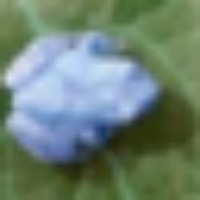

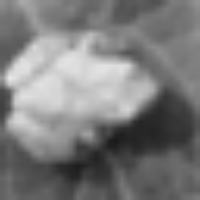

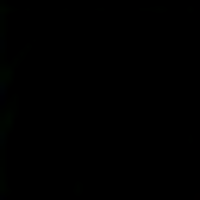

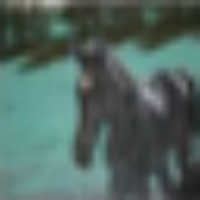

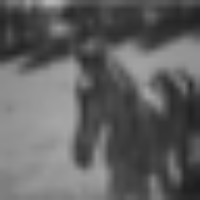

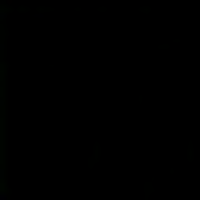

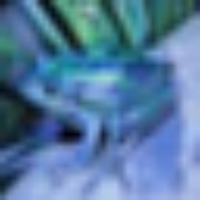

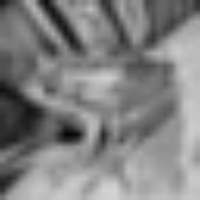

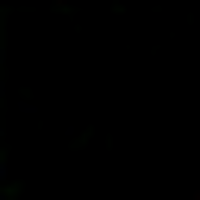

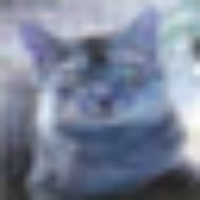

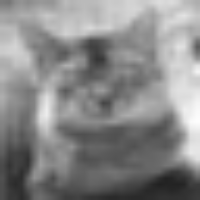

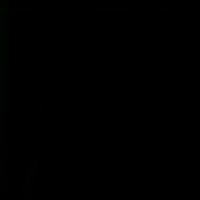

In [285]:
for i in range(4):
    cv2_imshow(cv2.resize(y[i], (200, 200)) * 255)
    cv2_imshow(cv2.resize(x[i], (200, 200)) * 255)
    cv2_imshow(cv2.resize(fake_imgs[i].numpy(), (200, 200)) * 255)

In [232]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dense(units=1, activation="linear"))
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1, activation="softmax"))
model.build((32,32,3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_342 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_343 (Conv2D)          (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 8, 8, 256)         0         
_________________________________________________________________
dense_76 (Dense)             (None, 8, 8, 1)           257       
_________________________________________________________________
dense_77 (Dense)             (None, 8, 8, 1)           2         
Total params: 299,011
Trainable params: 299,011
Non-trainable params: 0
________________________________________________